In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [2]:
import warnings
import gc
import numpy as np
import pandas as pd
import dask.dataframe as dd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problema principal
### Inferência Causal

Quando queremos analisar o peso de um tratamento em um outcome, realizamos experimentos. Os experimentos possuem grupo de controle e tratamento, que possuem distribuição similates e foram escolhidas aleatoriamente. Com isso, consegue-se eliminar eventuais viéses de seleção e poderemos comparar as diferenças no outcome advindas a partir daquele (e só dele) tratamento.

Entretanto, nem sempre é possível realizar experimentos. Daí se elaboraram as técnicas quasi-experimentais, que simulam experimentos a partir de dados observacionais. A ideia principal é eliminar o viés da análise e conseguir extrair dos eventos ocorridos, efeitos causais de um tratamento. É uma tarefa difícil, pois o viés pode estar em vários pontos da análise, e é complexo conseguir limpar todos os ruídos para compararmos laranjas com laranjas, e não laranjas com maçãs.

### Conectividade
Precisamos estimar efeito do acesso à internet, durante a pandemia, no desempenho escolar. Uma proxy do desempenho escolar que possui muitos dados disponíveis para análise são os scores do enem.
Uma análise de regressão entre a presença de internet e os scores, entretanto, sofre de vários possíveis problemas. Podemos estar comparando laranjas com maçãs, pois a presença de internet pode estar relacionada a outros fatores que influenciam no desempenho escolar. Por exemplo, a presença de internet pode estar relacionada a renda, que por sua vez está relacionada ao desempenho escolar. Ou seja, a presença de internet pode ser um proxy para a renda, e não para o desempenho escolar.

Mesmo controlando a renda na regressão, existem outros "cofounders" que podem estar envolvidos na presença de internet. Talvez pessoas com maior apoio familiar tenham mais probabilidade de ter acesso à internet. Isso afetaria tanto o tratamento quanto o outcome, e não conseguimos controlar esse viés. Esse é o problema da endogeneidade.

### Diferenças em Diferenças
A partir da análise de diferenças em diferenças, tentamos comparar uma evolução temporal entre grupos que recebem um tratamento e grupos que não recebem. A ideia é que, se os grupos seguirem uma evolução semelhante no tempo, e conhecendo as diferenças entre eles, a diferença no outcome gerada pelo tratamento seria observado na diferença entre as evoluções. Neste caso, não precisamos comparar maças com maças, mas podemos comparar a evolução de maças com a evolução de laranjas. A diferença entre as evoluções é o efeito do tratamento.




# Diferenças em Diferenças

### Investigando efeito das políticas estaduais de distribuição de chips e equipamentos frente estados que não realizaram intervenções durante a pandemia

Para calcular o efeito a partir da abordagem de diferenças em diferenças, utilizamos a seguinte equação:

$\hat{y} = \beta_0 + \beta_1 \times Treated + \beta_2 \times Post + \beta_3 \times Treated \times Post + \beta_i \times Cofound_i + ... + \beta_n \times Cofound_n$

Controlando para demais variáveis que produzam impacto no outcome. O efeito obtido então da política será o regressor $\beta_3$.

### Hipótese: 

Políticas de intervenção e subsídio ao acesso de internet amenizaram o impacto negativo do ensino remoto ao fornecer acesso a estudantes vulneráveis.

### Proxy para Tratamento:

Como não existem dados oficiais dos estados sobre a distribuição de chips e equipamentos por escola, utilizamos uma proxy dada pela probabilidade de cada aluno receber chips e equipamentos para cada município.

Essa probabilidade será calculada a partir da seguinte equação:

$E[Chip_ik] = \frac{(\dot{y_i} / n_k)(1 - b)}{a}$

- $E[Chip_i]$ é a probabilidade do aluno $i$ do município $k$ receber um chip/equipamento do governo;
- $\dot{y_i}$ é o número de chips/equipamentos distribuídos para o município $i$;
- $n_k$ é o número de alunos das escolas elegíveis para a política no município $k$;
- $a$ é a probabilidade de erro tipo-I: que o estudante receba acesso a internet mas não seja contabilizado na proxy;
- $b$ é a probabilidade de erro tipo-II: que o estudante não receba acesso a internet mesmo tendo cobertura no município;


# Análise empírica

To-do:

- Coletar informações sobre a distribuição de chips e equipamentos por município com data do início da política e mais detalhes;
- Plotar gráficos com a diferença entre o grupo de controle e de tratamento e a evolução nas notas médias, de português e matemática, de cada grupo no tempo;
- Construir proxy para tratamento;
- Realizar regressão e obter os estimadores de diferenças em diferenças;

In [3]:
from funs import *
from cols_list import cols_enem

## Funções

In [7]:
def agg_home_conditions(df):
    '''
    Cria um índice normalizado que representa a condição de moradia do aluno.
    '''

    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
    cols = ['Q007','Q008','Q009','Q010','Q012','Q014','Q016','Q019']
    for col in cols:
        df[col] = df[col].map(mapping, meta=(col, 'int'))

    series = df['Q007'] + df['Q008'] + \
    df['Q009'] + df['Q010'] + df['Q012'] + \
    df['Q014'] + df['Q016'] + df['Q019'] 
    
    min = series.min().compute()
    max = series.max().compute()

    normalized = series.apply(lambda x: x-min / max-min, meta=series)

    return normalized

In [6]:
def load_and_filter(year):
    '''
    Carrega um ano específico do dataset do ENEM, realiza a 
    filtragem das colunas e insere dados úteis para a análise.
    
    Parameters
    ----------
    year: int
        The year of the data to be loaded

    Returns
    -------
    df: dask.dataframe
        The filtered data
    '''
    cols_to_use = cols_enem + ['Q014', 'Q016', 'NO_MUNICIPIO_ESC']
    enem = filter_enem(dask_load_year_enem(year, cols_to_use), concluinte=True)
    gc.collect()
    enem['Q025'] = enem['Q025'].replace(['A','B'],[0,1])
    enem['NT_MEDIA'] = enem.apply(lambda row: get_medium_score(row), axis=1)
    enem['LOG_NT_MEDIA'] = np.log(enem['NT_MEDIA'])
    enem['LOG_NT_MT'] = np.log(enem['NU_NOTA_MT'])

    try:
        enem['IND_CASA'] = agg_home_conditions(enem)
    except Exception as e:
        print(e)
        print("Error on year {}".format(year))
        raise

    cleared = enem[['NU_ANO','CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC',
    'SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC', 
    'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC','LOG_NT_MT','NU_NOTA_LC',
    'NU_NOTA_MT','Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA',
    'LOG_NT_MEDIA']]
    
    return cleared

## Processamento e modelagem

### Nível individual

In [ ]:
data = dd.concat([load_and_filter(year) for year in range(2018,2022)])

In [ ]:
data = data.compute()

In [10]:
# persistindo dados para sessão posterior
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

### Ajustes na modelagem

Visualmente, a comparação entre estados com tratamento e sem tratamento não é clara. Porém. podemos realizar o ajuste em regressão para contornar os problemas da seleção amostral por meio do matching e verificar o estimador. 

Outra ideia possível é utilizar o modelo de diferenças em diferenças para estimar o efeito da política na presença de internet em casa. A partir desse estimador obtido, podemos inserir essa variável como instrumento na regressão original para analisar o efeito causal entre presença de internet e notas.

(1):

$Nota_i = \beta_0 + \beta_1 \times Cofound_1 + ... + \beta_n \times Cofound_n  + \mathbf{X_i \times INTERNET_i} + e_i$ 

(2):

$\mathbf{INTERNET_i} = \gamma_0 + \gamma_1 \times Treated + \gamma_2 \times Post + \mathbf{\gamma_3 \times Treated \times Post} +  ... + \gamma_n \times Cofound_n$

## DiDs

Datas das edições do Enem
- 2019: 03/11/2019 e 10/11/2019
- 2020: 17/01/2021 e 24/01/2021  
- 2021: 21/11/2021 e 28/11/2021
- 2022: 13/11/2022 e 20/11/2022

Como estou relacionando política e presença de internet, posso utilizar como tratados os alunos que receberam chips em 2020 já na edição do enem 2020.
Os que receberam chips em janeiro de 2021 não serão considerados como tratados na edição de 2020, pois não houve tempo suficiente para que a distribuição tenha sido concluída. Estes, serão considerados como tratados apenas em 2021.

### Observações

Como o enem não é um exame obrigatório, há um viés de seleção que pode ser alto no caso dessa análise. Uma possibilidade de contorno é utilizar os dados da PNAD para verificar a mudança no acesso à internet causado pelos programas estaduais.

In [4]:
def read_and_label_year(filename):
    df = pd.read_csv(filename, sep=';', encoding='utf-8', dtype={'Valor Transferido':float}, thousands='.',decimal=',')
    df['ANO'] = filename[-8:-4]
    return df

In [24]:
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import glob

In [15]:
# Carregando dataset persistido em outra sessão anterior
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

In [16]:
# Selecionando escolas públicas estaduais
data = data.query('TP_DEPENDENCIA_ADM_ESC == 2')

# TO-DO: Avaliar estados a serem comparados de acordo com critérios; proximidade geográfica, idh, etc.

#data = data[data['SG_UF_ESC'].isin(['PI', 'CE', 'BA', 'MA', 'PE', 'RN', 'SE', 'PA','AL','PA'])]

data['time'] = np.where(

        ((data['SG_UF_ESC'].isin(['MA', 'CE', 'PA'])) & (data['NU_ANO'] > 2019)) 
        |
        ((data['SG_UF_ESC'] == 'PI') & (data['NU_ANO'] > 2020)), 
     1, 
     0)

data['treated'] = np.where(data['SG_UF_ESC'].isin(['MA', 'CE', 'PA', 'PI']), 1, 0)

data['did'] = data['time'] * data['treated']

data['NAO_BRANCO'] = np.where(~data['TP_COR_RACA'].isin([1,4]), 1, 0)
data['MULHER'] = np.where(data['TP_SEXO'] == 'F', 1, 0)
data.drop(columns=['TP_SEXO'], inplace=True)

data.Q002 = data.Q002.fillna('H')
data.Q001 = data.Q001.fillna('H')
#data.Q006 = data.Q006.fillna(0)

data.IND_CASA = data.IND_CASA.fillna(0)
data.IND_CASA = data.IND_CASA.apply(lambda x: np.round(x, 2))
data['SOLTEIRO'] = np.where(data['TP_ESTADO_CIVIL'].isin([0,1]), 1, 0)

In [25]:
le = LabelEncoder()
for col in ['Q001', 'Q002', 'Q006', 'Q022', 'Q024']:
    arr = data[col].values
    le.fit(arr)
    data[col] = le.transform(arr)
data.Q001 = data.Q001 + 1
data.Q002 = data.Q002 + 1
data.Q001 = data.Q001.replace(8,0)
data.Q002 = data.Q002.replace(8,0) 

In [26]:
data.dropna(subset=['NT_MEDIA'], inplace=True)

In [27]:
def return_nan(df):
    na_cols = list()
    for col in df.columns:
        if df[col].isna().any():
            print(col, df[col].isna().sum())
            na_cols.append(col)
    return na_cols

In [28]:
na_cols = return_nan(data)

TP_ESTADO_CIVIL 13752
Q005 3412
Q025 3412


In [29]:
data.dropna(subset=na_cols, inplace=True)

In [30]:
# Salvando dataset com label de tratamento para Matching no R
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

### Nível Municipal

In [14]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

In [15]:
data.columns

Index(['NU_ANO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'LOG_NT_MT',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'Q001', 'Q002', 'Q005', 'Q006', 'Q022',
       'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA', 'LOG_NT_MEDIA', 'time',
       'treated', 'did', 'NAO_BRANCO', 'MULHER', 'SOLTEIRO'],
      dtype='object')

In [16]:
agg_dict = {
    'NT_MEDIA':'mean',
    'LOG_NT_MEDIA':'mean',
    'LOG_NT_MT':'mean',
    'NU_NOTA_LC':'mean',
    'NU_NOTA_MT':'mean',
    'Q001':'mean',
    'Q002':'mean',
    'Q005':'mean',
    'Q006':'mean',
    'Q022':'mean',
    'Q024':'mean',
    'Q025':'mean',
    'IND_CASA':'mean',
    'NAO_BRANCO': 'mean',
    'MULHER': 'mean',
    'TP_FAIXA_ETARIA':'mean',
    'SOLTEIRO': 'mean',
    'time': 'max',
    'treated': 'max',
    'did': 'max'
}

In [17]:
# Agregando dados dos estudantes de escolas estaduais a nível municipal
mun = data.groupby(['NU_ANO', 'SG_UF_ESC', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC'], as_index=False).agg(agg_dict)

In [18]:
# Inserindo covariáveis à nível municipal
query = """
SELECT ano
	,id_municipio
	,expectativa_anos_estudo
	,taxa_analfabetismo_15_a_17
	,taxa_atraso_0_medio
	,taxa_freq_bruta_medio
	,taxa_freq_15_17
	,indice_gini
	,idhm_e
	,idhm_l
	,idhm_r
FROM `basedosdados.mundo_onu_adh.municipio`
WHERE ano = 2010
"""

In [19]:
adh_m = pd.read_csv('../../Dados/Auxiliares/adh_onu.csv', dtype={'id_municipio':str}).drop(columns=['ano'])

In [20]:
print('Municípios criados após 2010:', mun[~mun['CO_MUNICIPIO_ESC'].isin(adh_m.id_municipio)].NO_MUNICIPIO_ESC.unique())

Municípios criados após 2010: ['Paraíso das Águas' 'Mojuí dos Campos' 'Pinto Bandeira' 'Pescaria Brava'
 'Balneário Rincão']


In [21]:
mun = mun.merge(adh_m, left_on='CO_MUNICIPIO_ESC', right_on='id_municipio')

In [22]:
mun.groupby('NU_ANO').size()

NU_ANO
2018.0    5540
2019.0    5528
2020.0    5398
2021.0    5439
dtype: int64

In [27]:
mun.treated = mun.treated.astype(np.uint8)

In [28]:
mun.isna().any()

NU_ANO                        False
SG_UF_ESC                     False
CO_MUNICIPIO_ESC              False
NO_MUNICIPIO_ESC              False
NT_MEDIA                      False
LOG_NT_MEDIA                   True
LOG_NT_MT                      True
NU_NOTA_LC                    False
NU_NOTA_MT                    False
Q001                          False
Q002                          False
Q005                          False
Q006                          False
Q022                          False
Q024                          False
Q025                          False
IND_CASA                      False
NAO_BRANCO                    False
MULHER                        False
TP_FAIXA_ETARIA               False
SOLTEIRO                      False
time                          False
treated                       False
did                           False
id_municipio                  False
expectativa_anos_estudo       False
taxa_analfabetismo_15_a_17    False
taxa_atraso_0_medio         

In [29]:
# Salvando dataset com label de tratamento para Matching no R
mun.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching-municipal.parquet')

### Visualizando tratamento

In [3]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

In [4]:
estados = ["MA", "PI", "RN", "PB", "PE", "AL", "SE", "PA", "CE"]

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
tratados = ["MA","CE","PA","PI"]
sns.set_style("whitegrid")
for i, estado in enumerate(tratados):
    sel = data.query(f'SG_UF_ESC == "{estado}"').reset_index(drop=True)
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y='NT_MEDIA', hue='Q025', ax=ax[i])
    ax[i].set_title(f'Tedendência para {estado}')

plt.tight_layout()

plt.show()

Evolução interior nos estados tratados

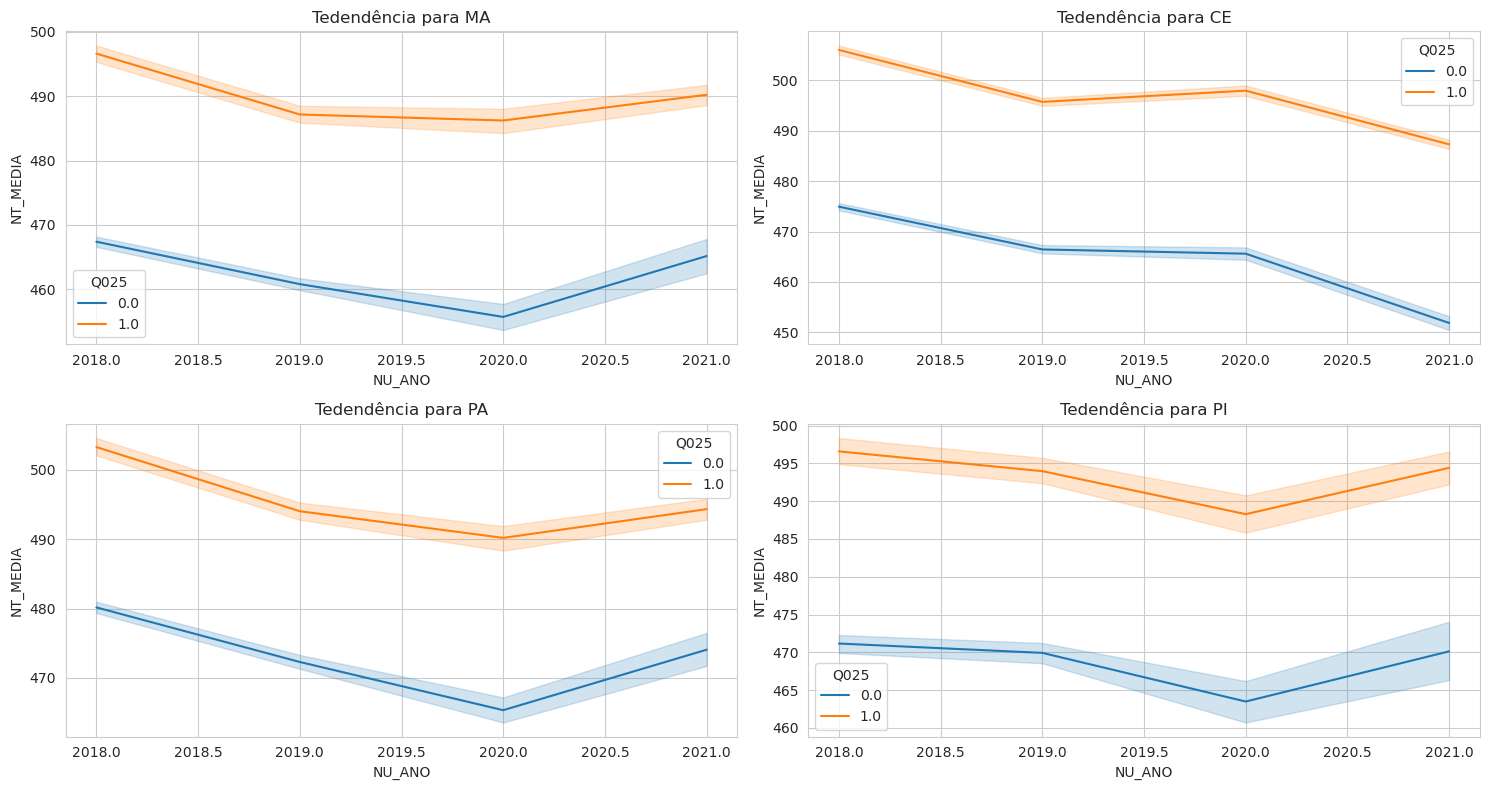

In [47]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
tratados = ["MA","CE","PA","PI"]
sns.set_style("whitegrid")
for i, estado in enumerate(tratados):
    sel = data.query(f'SG_UF_ESC == "{estado}"').reset_index(drop=True)
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y='NT_MEDIA', hue='Q025', ax=ax[i])
    ax[i].set_title(f'Tedendência para {estado}')

plt.tight_layout()

plt.show()

### Matching

Para o processamento se assimilar ao máximo a um experimento "fully blocked", é necessário realizar o matching entre os grupos de controle e tratamento. Com isso, tenta eliminar-se vieses e desbalanceamento na análise.

#### Mahalanobis Distance Matching
$Distance(X_i, X_j) = \sqrt{(X_i - X_j)^T \Sigma^{-1} (X_i - X_j)}$

"It is like an euclidean distance, but you standarize all the variables" - Prof. Gary King

- Match each treated unit to a control unit with the smallest distance
- Control units not reused, pruned if unused
- Prune matches if Distance > caliper

Considerations: 
The standarization used in mahalanobis method is a function of the dataset, wich is not ideal. "Mahalanobis is for methodologists, in applications, use Euclidean distance" - Prof. Gary King

#### Coarsened Exact Matching
$X_i = (X_{i1}, X_{i2}, ..., X_{in})$ Covariates

$C(X_i) = coarsen(X_i)$

- Coarsen covariates
- Apply exact matching on coarsened covariates
- Prune data and apply wheigthing


### Análise para notas

In [46]:
f = '../../Resultados/Agg/ENEM/aux/postMatching/data-municipal-*.parquet'
data_mun = pd.concat([pd.read_parquet(f) for f in glob(f)]).reset_index(drop=True)

In [56]:
sns.set_style('ticks')

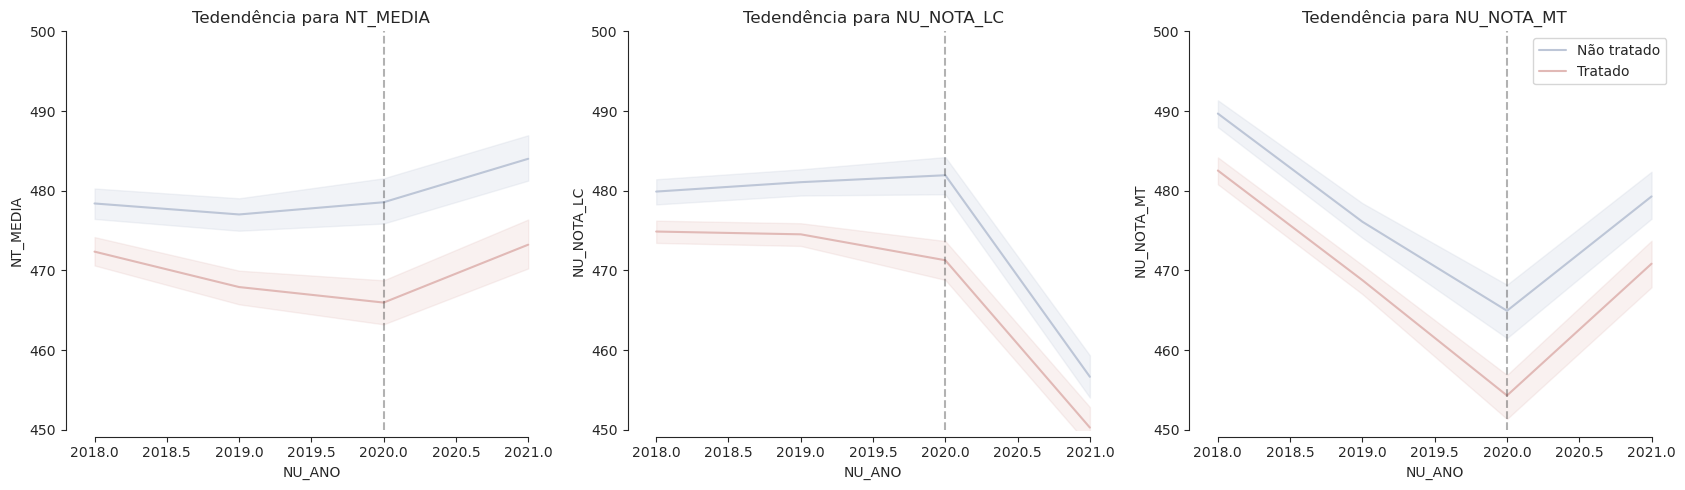

In [160]:
fig, ax = plt.subplots(1,3,figsize=(17,5))
ax = ax.flatten()
notas = ['NT_MEDIA', 'NU_NOTA_LC', 'NU_NOTA_MT']
sns.set_style("ticks")
for i, nota in enumerate(notas):
    sel = data_mun.copy()
    sel.treated = sel.treated.replace({0:'Não tratado', 1:'Tratado'})
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y=nota, hue='treated', palette='vlag', ax=ax[i])
    ax[i].set_title(f'Tedendência para {nota}')
    ax[i].axvline(2020, color='black', linestyle='--', alpha=0.3)
    ax[i].set_ylim([450,500])
    ax[i].get_legend().remove()

sns.despine(offset=5, trim=True)

plt.legend()
plt.tight_layout()
plt.show()

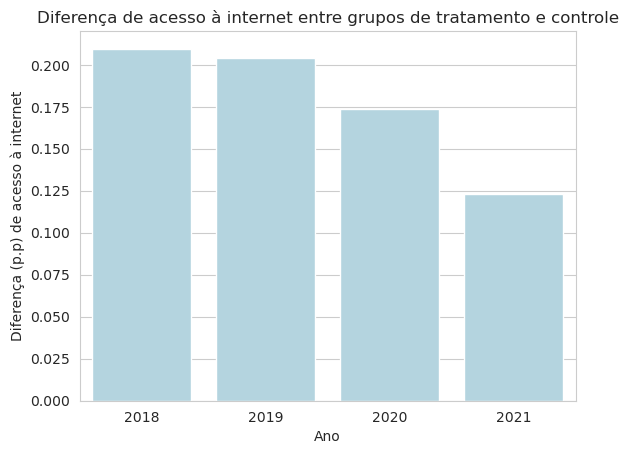

In [163]:
net_x_ano = data_mun.groupby(['NU_ANO', 'treated'], as_index=False)['Q025'].mean()
net_x_ano['diff_tratado_controle']= abs(net_x_ano['Q025'].diff())
net_x_ano = net_x_ano[net_x_ano['treated']==1]
sns.set_style('whitegrid')
sns.barplot(data=net_x_ano, x='NU_ANO', y='diff_tratado_controle', color='lightblue')
plt.title('Diferença de acesso à internet entre grupos de tratamento e controle')
plt.xlabel('Ano')
plt.ylabel('Diferença (p.p) de acesso à internet')
plt.show()

In [83]:
data_mun.columns

Index(['NU_ANO', 'SG_UF_ESC', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
       'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA',
       'NAO_BRANCO', 'MULHER', 'TP_FAIXA_ETARIA', 'SOLTEIRO', 'time',
       'treated', 'did', 'id_municipio', 'expectativa_anos_estudo',
       'taxa_analfabetismo_15_a_17', 'taxa_atraso_0_medio',
       'taxa_freq_bruta_medio', 'taxa_freq_15_17', 'indice_gini', 'idhm_e',
       'idhm_l', 'idhm_r', 'X__index_level_0__', 'weights', 'subclass'],
      dtype='object')

In [93]:
data_mun.head()

,NU_ANO,SG_UF_ESC,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,NT_MEDIA,LOG_NT_MEDIA,LOG_NT_MT,NU_NOTA_LC,NU_NOTA_MT,Q001,...,taxa_atraso_0_medio,taxa_freq_bruta_medio,taxa_freq_15_17,indice_gini,idhm_e,idhm_l,idhm_r,X__index_level_0__,weights,subclass
0,2018,AL,2700102,Água Branca,486.402909,6.179400,6.171530,480.756364,484.436364,2.090909,...,56.03,59.30,78.89,0.56,0.432,0.728,0.527,87,2.744630,1
1,2018,MA,2106607,Matões,482.843968,6.169173,6.169932,479.207143,484.112698,2.595238,...,65.21,58.11,80.11,0.56,0.434,0.739,0.519,4904,0.563842,1
2,2018,MA,2110906,São Francisco do Maranhão,459.122069,6.122399,6.124473,454.244828,461.431034,2.172414,...,61.42,50.95,83.75,0.57,0.400,0.733,0.503,5155,0.563842,1
3,2018,PI,2205599,Lagoa do Sítio,458.082857,6.116365,6.147690,458.185714,471.450000,2.678571,...,71.43,57.62,83.54,0.55,0.421,0.745,0.504,12192,0.563842,1
4,2018,PI,2210409,São Miguel do Tapuio,469.691622,6.144153,6.177898,485.622973,486.732432,2.229730,...,59.82,67.24,84.30,0.57,0.434,0.780,0.508,12537,0.563842,1


In [101]:
data_mun.shape

(3290, 37)

In [99]:
data_mun.weights.sum()

3290.0

In [98]:
data_mun.groupby('NU_ANO')['weights'].sum()

NU_ANO
2018    838.0
2019    839.0
2020    833.0
2021    780.0
Name: weights, dtype: float64

In [116]:
y = data_mun['NT_MEDIA']
x = data_mun[['time', 'treated', 'did', 'Q025']]
w = data_mun['weights']

In [96]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time       False
treated    False
did        False
Q025       False
dtype: bool


In [115]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               NT_MEDIA   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     69.96
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           6.31e-57
Time:                        17:53:22   Log-Likelihood:                -15263.
No. Observations:                3290   AIC:                         3.054e+04
Df Residuals:                    3285   BIC:                         3.057e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        462.0964      1.485    311.138      0.0

In [102]:
indiv = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

In [105]:
estados = ["MA", "PI", "RN", "PB", "PE", "AL", "SE", "PA", "CE"]
indiv = indiv[indiv['SG_UF_ESC'].isin(estados)]

In [112]:
y = indiv['NU_NOTA_LC']
x = indiv[['time', 'treated', 'did', 'Q025']]

In [113]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_LC   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     5324.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:52:46   Log-Likelihood:            -3.8278e+06
No. Observations:              682203   AIC:                         7.656e+06
Df Residuals:                  682198   BIC:                         7.656e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        477.9823      0.189   2535.123      0.0

### Análise para presença de internet

Carregando a inserindo dados do auxílio emergencial

In [ ]:
f = '../../Dados/Auxilio Emerg/beneficio_*.csv'
auxi = pd.concat([read_and_label_year(f) for f in glob.glob(f)])

In [ ]:
data.NO_MUNICIPIO_ESC = data.NO_MUNICIPIO_ESC.str.upper()

In [ ]:
# Correção de nomes de municípios
auxi['Município'] = auxi['Município'].replace({
    'SANTA ISABEL DO PARÁ':'SANTA IZABEL DO PARÁ',
    'ITAPAGÉ':'ITAPAJÉ',
    'ARAÇAS':'ARAÇÁS',
    'IGUARACI':'IGUARACY',
    'SÃO VICENTE FÉRRER':'SÃO VICENTE FERRER',
    'ELDORADO DOS CARAJÁS':'ELDORADO DO CARAJÁS',
    "OLHO-D'ÁGUA DO BORGES":"OLHO D'ÁGUA DO BORGES",
    'IUIÚ':'IUIU',
    'MUQUÉM DE SÃO FRANCISCO':'MUQUÉM DO SÃO FRANCISCO',
    'ERERÉ':'ERERÊ',
    'AMPARO DO SÃO FRANCISCO':'AMPARO DE SÃO FRANCISCO',
    })
data.NO_MUNICIPIO_ESC = data.NO_MUNICIPIO_ESC.replace({
    'SÃO VICENTE FÉRRER':'SÃO VICENTE FERRER',
    'AMPARO DO SÃO FRANCISCO':'AMPARO DE SÃO FRANCISCO',
    'ERERÉ':'ERERÊ',
    })

In [ ]:
data[~data.NO_MUNICIPIO_ESC.isin(auxi['Município'].unique())].NO_MUNICIPIO_ESC.unique()

array(['SERRA CAIADA'], dtype=object)

In [ ]:
auxi.rename(columns={'Município':'NO_MUNICIPIO_ESC', 'ANO':'NU_ANO', 'Valor Transferido': 'AUX_EMERG'}, inplace=True)
auxi.NU_ANO = auxi.NU_ANO.astype(int)
merged = pd.merge(data, auxi[['NO_MUNICIPIO_ESC', 'NU_ANO','AUX_EMERG']], on=['NO_MUNICIPIO_ESC', 'NU_ANO'], how='left')

In [ ]:
merged.AUX_EMERG = merged.AUX_EMERG.fillna(0)
merged.AUX_EMERG = (merged.AUX_EMERG-merged.AUX_EMERG.min())/(merged.AUX_EMERG.max()-merged.AUX_EMERG.min())

In [1]:
# Inserindo partido dos governos estaduais
gov = pd.read_csv('../../Dados/Auxiliares/GovernosEstaduais.csv', decimal=',', thousands='.')
gov.columns = ['UF','SG_UF_ESC','GOV','PARTIDO','PERIODO','NOTAS','INDICE']
gov = gov[['SG_UF_ESC','INDICE']]
#gov = pd.get_dummies(gov, columns=['PARTIDO'], prefix='PARTIDO')

NameError: name 'pd' is not defined

In [16]:
merged = merged.merge(gov, on='SG_UF_ESC', how='left')

In [17]:
# inserindo desempenho no ideb
ideb = pd.read_csv('../../Dados/Auxiliares/idebPorEstado.csv')
merged = merged.merge(ideb, on='SG_UF_ESC', how='left')

In [18]:
# inserindo IDH estadual
idh = pd.read_csv('../../Dados/Auxiliares/idh_estadual_2010_cleaned.csv').rename(columns={'SG_UE':'SG_UF_ESC'})
merged = merged.merge(idh, on='SG_UF_ESC', how='left')

In [19]:
merged.dropna(subset=['Q025'], inplace=True)

In [20]:
y = merged['Q025'].values
d = merged['treated'].values
x = merged[['time', 'treated', 'did', 'NAO_BRANCO', 'IND_CASA', 'Q006', 'AUX_EMERG']]
cofounders = ['NAO_BRANCO', 'IND_CASA', 'Q006', 'AUX_EMERG','NOTA19', 'INDICE','IDHM_RENDA', 'IDHM_LONGEVIDADE', 'IDHM_EDUCACAO']

In [21]:
from causalinference import CausalModel
model = CausalModel(y,d,merged[cofounders].values)

In [22]:
model.est_propensity()

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [23]:
print(model.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept   -629.409463466079.601     -0.000      1.000-908394145.427908392886.608
            X0      0.474   1973.349      0.000      1.000  -3867.290   3868.238
            X1      0.031    394.644      0.000      1.000   -773.472    773.534
            X2     -0.422    275.496     -0.002      0.999   -540.395    539.552
            X3      1.130  15052.872      0.000      1.000 -29502.498  29504.759
            X4      2.76544492908.633      0.000      1.000-87206098.15587206103.685
            X5     17.497132964661.737      0.000      1.000-260610719.507260610754.501
            X6  -3258.848389119403.661     -0.000      1.000-762677290.024762670772.329
            X7   3262.407546594187.998      0.000      1.000-1071321346.0681071327870.882
            X8    234.454       

In [25]:
x['score'] = model.propensity['fitted']

/tmp/ipykernel_31192/1818189395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['score'] = model.propensity['fitted']


In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [27]:
x[['treated','score']]

,treated,score
0,0,0.000
1,1,1.000
2,0,0.000
3,0,0.000
4,1,1.000
...,...,...
1097274,1,1.000
1097275,0,0.000
1097276,0,0.000
1097277,0,0.000


In [169]:
model.trim()

ValueError: Too few control units: N_c < K+1

In [22]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time          False
treated       False
did           False
NAO_BRANCO    False
IND_CASA      False
Q006          False
AUX_EMERG     False
dtype: bool


In [23]:
y = y.astype(int)

In [27]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit(cov_type='cluster', cov_kwds={'groups':merged['NO_MUNICIPIO_ESC']})
# Robust standard errors: cov_type='HC3'
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q025   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1053.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:20:49   Log-Likelihood:            -6.5060e+05
No. Observations:             1095953   AIC:                         1.301e+06
Df Residuals:                 1095946   BIC:                         1.301e+06
Df Model:                           6                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1842      0.020      8.997      0.0

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '
